In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

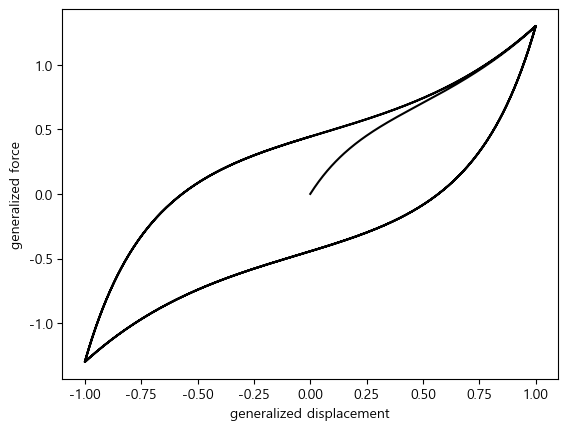

In [2]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 3 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)
uj_result = []

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)

count_reuslt = []
# CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # Update the history variable
    uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
    # Evaluate the generalized force at time t
    uj_result.append(uj)

    if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
        count_reuslt.append(i)
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
    else:
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

# PLOT
plt.figure()
plt.plot(u, f, 'k')
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.show()


In [22]:
f0

0.45

In [23]:
u0

4.755577925665719

In [24]:
import math
import latexify

$$ -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0 $$

In [25]:
@latexify.with_latex
def boucwen(u):
    return -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0

In [26]:
boucwen

In [3]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from keras import optimizers

In [4]:
total = pd.DataFrame()
total['u'] = u
total['time'] = t
total['f'] = f


In [5]:
x = total.iloc[:,0:2]
y = total.f

In [6]:
x_tf = tf.convert_to_tensor(x.values)
y_tf = tf.convert_to_tensor(y)

x_tr = x_tf[:2000]
x_te = x_tf[2000:]
y_tr = y_tf[:2000]
y_te = y_tf[2000:]

In [7]:
x_tr = tf.cast(x_tr, tf.float32)
x_te = tf.cast(x_te, tf.float32)
y_tr = tf.cast(y_tr, tf.float32)
y_te = tf.cast(y_te, tf.float32)

In [8]:
class PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

@tf.function
def compute_boucwen_dynamics(u, z, A, B, G, n):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(u)  
        tape.watch(z)
        z = tf.clip_by_value(z, -1e2, 1e2)

        Z_dot = A*(u - B*z - G*(tf.abs(z)**n)*tf.sign(z))

    dZ_dot_du = tape.gradient(Z_dot, u)
    dZ_dot_dz = tape.gradient(Z_dot, z)
    
    return dZ_dot_du, dZ_dot_dz

def boucwen_loss(y_true, y_pred, u, z, A, B, G, n):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    dZ_dot_du, dZ_dot_dz = compute_boucwen_dynamics(u, z, A, B, G, n)
    
    physics_loss = tf.reduce_mean(tf.square(y_pred - dZ_dot_dz))
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return 0.5 * physics_loss + 0.5 * data_loss  


def train_step_boucwen(x_tr, y_tr, A, B, G, n):
    u = x_tr[:, 0]
    u = tf.convert_to_tensor(u)

    with tf.GradientTape() as tape:
        z = model_pinn_boucwen(x_tr, training=True)
        y_pred = z  
        loss_value = boucwen_loss(y_tr, y_pred, u, z, A, B, G, n)
    gradients = tape.gradient(loss_value, model_pinn_boucwen.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn_boucwen.trainable_variables))
    return loss_value


In [9]:
model_pinn_boucwen = PINN_BoucWen(1)

In [10]:
z_1 = model_pinn_boucwen(x_tr)

In [11]:
z_1

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[ 0.        ],
       [-0.00050191],
       [-0.00100379],
       ...,
       [-0.08970664],
       [-0.09014643],
       [-0.09058616]], dtype=float32)>

In [12]:
tf.clip_by_value(z_1, -1e2, 1e2)

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[ 0.        ],
       [-0.00050191],
       [-0.00100379],
       ...,
       [-0.08970664],
       [-0.09014643],
       [-0.09058616]], dtype=float32)>

In [13]:
A = 3  
B = 5  
G = 1  
n = 2000

In [14]:
u = tf.convert_to_tensor(u)

In [15]:
z_1

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[ 0.        ],
       [-0.00050191],
       [-0.00100379],
       ...,
       [-0.08970664],
       [-0.09014643],
       [-0.09058616]], dtype=float32)>

In [16]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x_tr)  
    tape.watch(z_1)
    z_1 = tf.clip_by_value(z_1, -1e2, 1e2)

    Z_dot = A*(x_tr - B*z_1 - G*(tf.abs(z_1)**n)*tf.sign(z_1))

    dZ_dot_du = tape.gradient(Z_dot, x_tr)
    dZ_dot_dz = tape.gradient(Z_dot, z_1)
print(dZ_dot_du)
print(dZ_dot_dz)

tf.Tensor(
[[3. 3.]
 [3. 3.]
 [3. 3.]
 ...
 [3. 3.]
 [3. 3.]
 [3. 3.]], shape=(2000, 2), dtype=float32)
tf.Tensor(
[[-30.]
 [-30.]
 [-30.]
 ...
 [-30.]
 [-30.]
 [-30.]], shape=(2000, 1), dtype=float32)


In [17]:
A*(x_tr - B*z_1 - G*(tf.abs(z_1)**n)*tf.sign(z_1))

<tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[0.        , 0.        ],
       [0.02637801, 0.01052858],
       [0.05275499, 0.02105688],
       ...,
       [1.2890542 , 7.3366    ],
       [1.3144983 , 7.346196  ],
       [1.3399429 , 7.355792  ]], dtype=float32)>

In [18]:
epochs = 500
A = 3  
B = 5  
G = 1  
n = 2000

optimizer =  tf.keras.optimizers.Adam(learning_rate=0.01)



In [38]:
for epoch in range(epochs):
    loss_value = train_step_boucwen(x_tr, y_tr, A, B, G, n)
    print('Training loss at epoch %s: %s' % (epoch, float(loss_value)))

TypeError: Binding inputs to tf.function `compute_boucwen_dynamics` failed due to `too many positional arguments`.Received args: (<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([ 0.        ,  0.00628314,  0.01256604, ..., -0.01884844,
       -0.01256604, -0.00628314], dtype=float32)>, <tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[0.        ],
       [0.00019472],
       [0.00038943],
       ...,
       [0.17963257],
       [0.17934585],
       [0.17905912]], dtype=float32)>, <tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[ 0.        ],
       [-0.00047829],
       [-0.00095657],
       ...,
       [-0.13408984],
       [-0.13415356],
       [-0.1342174 ]], dtype=float32)>, 3, 5, 1, 2000) and kwargs: {} for signature: (u, z, A, B, G, n).

In [26]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.tanh, dtype = tf.float32)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh, dtype=tf.float32)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

model = PINN(2, 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

epochs = 500

ka = tf.constant(5.0, dtype=tf.float32)
kb = tf.constant(0.5, dtype=tf.float32)
alfa = tf.constant(5.0, dtype=tf.float32)
beta = tf.constant(1.0, dtype=tf.float32)

u0 = tf.cast(-(1 / (2 * alfa)) * tf.math.log(10 ** -20 / (ka - kb)), tf.float32)
f0 = tf.cast(((ka - kb) / (2 * alfa)) * (1 - tf.exp(-2 * alfa * u0)), tf.float32)

u = tf.cast(u, dtype=tf.float32)
v = tf.cast(v, dtype=tf.float32)
# uj = tf.cast(tf.zeros_like(u), dtype=tf.float32)
# f = tf.cast(tf.zeros_like(u), dtype=tf.float32)

uj_initial_value = np.array([0.0])  # 초기값 설정
f_initial_value = np.zeros_like(uj_initial_value)  # 초기값 설정

uj = tf.Variable(uj_initial_value, dtype=tf.float32)
f = tf.Variable(f_initial_value, dtype=tf.float32)


@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj, f):
    with tf.GradientTape() as tape:
        tape.watch(u)
        i = 1
        uj_value = u[i-1] + 2*u0*tf.sign(v[i]) + tf.sign(v[i])*(1/alfa)*tf.math.log(tf.abs(tf.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+tf.exp(beta*u[i-1])-tf.exp(-beta*u[i-1])+kb*u[i-1]+tf.sign(v[i])*((ka-kb)/alfa)*tf.exp(-2*alfa*u0)+tf.sign(v[i])*f0-f[i-1])))
        uj.assign(uj_value)
        f[i].assign(-2*beta*u[i] + tf.exp(beta*u[i]) - tf.exp(-beta*u[i]) + kb*u[i] - tf.sign(v[i])*((ka-kb)/alfa)*(tf.exp(-alfa*(tf.sign(v[i])*(u[i]-uj)+2*u0))-tf.exp(-2*alfa*u0)) + tf.sign(v[i])*f0)

    df_du = tape.gradient(f[i], u[i])

    return df_du


@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj, f):
    i = 0
    with tf.GradientTape() as tape:
        tape.watch(u)
        uj_value = u[i] + 2 * u0 * tf.sign(v[i]) + tf.sign(v[i]) * (1 / alfa) * tf.math.log(
            tf.abs(
                tf.sign(v[i])
                * (alfa / (ka - kb))
                * (
                    -2 * beta * u[i]
                    + tf.exp(beta * u[i])
                    - tf.exp(-beta * u[i])
                    + kb * u[i]
                    + tf.sign(v[i])
                    * ((ka - kb) / alfa)
                    * tf.exp(-2 * alfa * u0)
                    + tf.sign(v[i]) * f0
                    - f[0]
                )
            )
        )
        uj.assign(uj_value)
        f[0].assign(
            -2 * beta * u[i]
            + tf.exp(beta * u[i])
            - tf.exp(-beta * u[i])
            + kb * u[i]
            - tf.sign(v[i]) * ((ka - kb) / alfa) * (tf.exp(-alfa * (tf.sign(v[i]) * (u[i] - uj) + 2 * u0)) - tf.exp(-2 * alfa * u0))
            + tf.sign(v[i]) * f0
        )
    df_du = tape.gradient(f[0], u)
    return df_du



def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    u, v = tf.split(x_tr, 2, axis=-1)  
    
    df_du = compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj, f)
    df_du = tf.expand_dims(df_du, axis=-1)

    physics_loss = tf.reduce_mean(tf.square(y_pred - df_du))
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return physics_loss + data_loss

def train_step(x_tr, y_tr):
    with tf.GradientTape() as tape:
        y_pred = model(x_tr, training=True)  
        loss_value = custom_loss(y_tr, y_pred)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value



In [ ]:
for epoch in range(epochs):
    loss_value = train_step(x_tr, y_tr)
    if epoch % 50 == 0:
        print('Training loss at epoch %d: %s' % (epoch, float(loss_value)))

In [124]:

tf.keras.backend.clear_session()

In [320]:
class PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

@tf.function
def compute_boucwen_dynamics(u, z, A, B, G, n):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(u)  
        tape.watch(z)
        # z = tf.clip_by_value(z, -1e2, 1e2)
        Z_dot = A*u - B*(tf.abs(u)*tf.abs(z)**(n-1)*z) - G*u*tf.abs(z)**n

    dZ_dot_du = tape.gradient(Z_dot, u)
    dZ_dot_dz = tape.gradient(Z_dot, z)
    
    return dZ_dot_du, dZ_dot_dz

def boucwen_loss(y_true, y_pred, u, z, A, B, G, n):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    dZ_dot_du, dZ_dot_dz = compute_boucwen_dynamics(u, z, A, B, G, n)
    
    physics_loss = tf.reduce_mean(tf.square(y_pred - dZ_dot_du))
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return 0.5 * physics_loss + 0.5 * data_loss  

def train_step_boucwen(x_tr, y_tr, A, B, G, n):
    u = x_tr[:, 0]
    u = tf.convert_to_tensor(u)

    with tf.GradientTape() as tape:
        z = model_pinn_boucwen(x_tr, training=True)
        y_pred = z  
        loss_value = boucwen_loss(y_tr, y_pred, u, z, A, B, G, n)
    gradients = tape.gradient(loss_value, model_pinn_boucwen.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn_boucwen.trainable_variables))
    return loss_value


In [321]:
model_pinn_boucwen = PINN_BoucWen(output_dim=1)

In [322]:
optimizer.build(model_pinn_boucwen.trainable_variables)

In [323]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [324]:
epochs = 300

In [325]:
A = 0.1
B = 0.1
G = 0.1
n = 5

In [326]:
for epoch in range(epochs):
    loss_value = train_step_boucwen(x_tr, y_tr, A, B, G, n)
    print('Training loss at epoch %d: %s' % (epoch, float(loss_value)))

Training loss at epoch 0: 19944.318359375
Training loss at epoch 1: 19740.734375
Training loss at epoch 2: 18988.6484375
Training loss at epoch 3: 16879.08203125
Training loss at epoch 4: 12467.7607421875
Training loss at epoch 5: 12019.9794921875
Training loss at epoch 6: 10151.5087890625
Training loss at epoch 7: 10245.5517578125
Training loss at epoch 8: 10849.43359375
Training loss at epoch 9: 10733.3349609375
Training loss at epoch 10: 10141.1552734375
Training loss at epoch 11: 9973.5439453125
Training loss at epoch 12: 10569.3203125
Training loss at epoch 13: 10229.248046875
Training loss at epoch 14: 9916.7373046875
Training loss at epoch 15: 10165.068359375
Training loss at epoch 16: 10333.8525390625
Training loss at epoch 17: 10183.025390625
Training loss at epoch 18: 9939.3017578125
Training loss at epoch 19: 10003.935546875
Training loss at epoch 20: 10204.3466796875
Training loss at epoch 21: 10032.1865234375
Training loss at epoch 22: 9916.3984375
Training loss at epoch 2

In [327]:
model_pinn_boucwen(x_te)

<tf.Tensor: shape=(1001, 1), dtype=float32, numpy=
array([[0.97194093],
       [0.97327536],
       [0.97460985],
       ...,
       [1.3504238 ],
       [1.3519334 ],
       [1.3536192 ]], dtype=float32)>

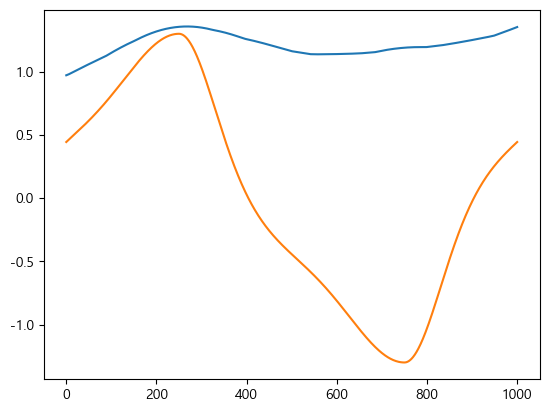

In [328]:
plt.plot(model_pinn_boucwen(x_te))
plt.plot(y_te)

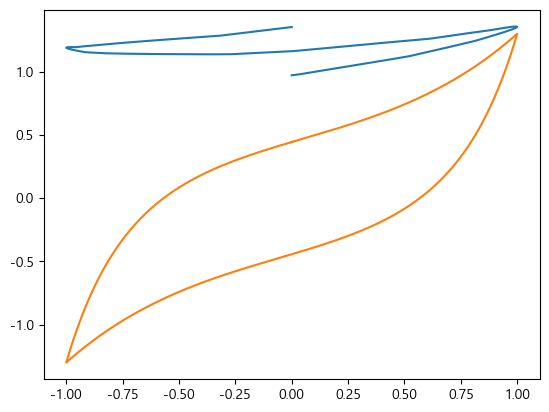

In [330]:
plt.plot(x.u[2000:], model_pinn_boucwen(x_te))
plt.plot(x.u[2000:], y_te)